It is recommended that you read this in Colab, even if you don't run it, so that the boring cells are collapsed

<a target="_blank" href="https://colab.research.google.com/github/Computational-physics-with-learning/PINNs/blob/main/LinearAdaptation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#@title Install functorch: will restart kernel, ignore 'session crashed for unknown reason' warning
%%capture
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/code/utils.py
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/code/torch_utils.py
!pip install functorch==0.2.1 # specific version otherwise it updates colab's torch and cuda installations too...
get_ipython().kernel.do_shutdown(True)

In [2]:
#@title Import packages
from utils import (np, plt, makedir, os, tqdm, plot2d,
    getEvalPoints2D, plotcompare2d, randParams1D, heatfunc1D, advectionfunc1D)
from torch_utils import (pt, time, str2loss, DenseNN, Basic_model, 
    to_device, from_device, plotHistory)

from typing import Optional, Tuple
import numpy as np
import functorch as ftch

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch import Tensor

# Adaptation by Linearisation 
This notebook attempts to use the method proposed by [Maddox, Tang, Moreno, Wilson, and Damianou](https://arxiv.org/pdf/2103.01439.pdf) in the training of PINNs. We wanted to speed up the training of PINNs by pre-training to a 'simple' problem, and then fine-tuning with this linearisation method.

In the wording of the reference, we first train on task 1 and adapt to task 2. It's not clear what would be the best 'simple' task 1 which still well-approximates the full task 2. We have tried giving coarse boundary conditions first, and then fine-tuning to the high-resolution boundary.

In [3]:
#@title Copy of PINN-specific functions from the PINNS notebook

class PINN_model(Basic_model):
    def __init__(self, X_u, u_true, X_f, f, u, loss):
        '''
        Learns the parameters of u to satisfy u(X_u) = u_true and a 
        constraint f(u) = 0 at points X_f.
        Parameters:
        -----------
            X_u : array of shape (N,d)
            u_true : array of shape (N,S)
            X_f : array of shape (M,d)
            f : mapping from pairs (X,u) to a constraint violation value
            u : mapping from R^d to R^S
            loss : str, (str,str), or (func, func), or (func, scalar, func)
        '''
        Basic_model.__init__(self, u)

        self.X_u = to_device(X_u, grad=False)
        self.u_true = to_device(u_true, grad=False)
        self.X_f = to_device(X_f, grad=True)
        self.X = pt.cat((self.X_u, self.X_f), axis=0).unique(sorted=False, dim=0)
        self.f = f
        if type(loss) is str:
            loss = (str2loss(loss), 1, str2loss(loss))
        else:
            loss = tuple((str2loss(L) if type(L) is str else L) for L in loss)
        if len(loss) == 2:
            loss = (loss[0], 1, loss[1])
        self._loss = loss
    
    def loss(self):
        # Compute pointwise loss
        if self.X_u.numel()>0:
            loss_u = self._loss[0](self.u(self.X_u), self.u_true)
        else:
            loss_u = pt.tensor(0.0)

        # Compute constraint loss
        if self.X_f.numel()>0:
            F = self.f(self.X_f, self.u)
            loss_f = self._loss[2](F, pt.zeros_like(F))
        else:
            loss_f = pt.tensor(0.0)

        # return balance of losses
        return loss_u + self._loss[1] * loss_f

    def predict(self, X=None, constraint=False):
        if X is None:
            X = self.X
        elif not pt.is_tensor(X):
            X = to_device(X, grad=constraint)
        return from_device(self.f(X, self.u) if constraint else self.u(X))

def Advection_pde1D(beta):
    beta = to_device(beta)

    def f(X, u):
        U = u(X)
        dU = pt.autograd.grad(U, X,  # first derivative in (time, space)
                              grad_outputs=pt.ones_like(U),
                              retain_graph=True, create_graph=True)[0]
        U_t, U_x = dU[:, [0]], dU[:, [1]]
        return U_t + beta * U_x
    return f


def Heat_pde1D(beta):
    beta = to_device(beta)

    def f(X, u):
        U = u(X)
        dU = pt.autograd.grad(U, X,  # first derivative
                              grad_outputs=pt.ones_like(U),
                              retain_graph=True,
                              create_graph=True)[0]
        U_t, U_x = dU[:, [0]], dU[:, [1]]
        U_xx = pt.autograd.grad(U_x, X,  # second derivative
                                grad_outputs=pt.ones_like(U_x),
                                retain_graph=True,
                                create_graph=True)[0][:, [1]]
        return U_t - beta * U_xx
    return f

def PINNrun(X_u, u, X_f, f, layers=[60]*4, activation='tanh', load=None,
            optimise=(
                (5e3,'Adam',{'threshold':1e-3},{'lr':1e-3}),
                (1e4,'LBFGS',{},{'line_search_fn':None,'tolerance_change':1e-14}),
            ), loss=('MSE',.1,'MSE'), verbosity=1, print_freq=1000):
    '''
    model = PINNrun(X_u, u, X_f, f, layers=[60]*4, activation='tanh', load=None,
            optimise=(
                (5e3,'Adam',{'threshold':1e-3},{'lr':1e-3}),
                (1e4,'LBFGS',{},{'line_search_fn':None,'tolerance_change':1e-14}),
            ), loss=('MSE',.1,'MSE'), verbosity=1, print_freq=1000)

    Parameters:
    -----------
        X_u: array of shape (N, d), dtype=float32
            Points at which to fit function u
        u: array of shape (N,), dtype=float32
            Values of the true function u at points X_u
        X_f: array of shape (M, d), dtype=float32
            Points at which to enforce constraint
        f: mapping from R^d to R
            Attempt to enforce f(x,u) = 0
        layers: list of ints
            The function u will be modelled as a dense NN with these hidden 
            layers. Default is [60]*4
        activation: str
            Name of activation function to use, default is tanh.
        optimise: tuple of training instructions
            Default is: (
                (5e3,'Adam', {'threshold':1e-3}, {'lr':1e-3}),
                (1e4,'LBFGS', {}, {'line_search_fn':None,'tolerance_change':1e-14}),
            )
            which first performs 5e3 iterations of Adam with learning rate 1e-3 and early 
            stopping if the loss reaches 1e-3, this is followed by 1e4 iterations 
            of LBFGS with the specified algorithm parameters.
            See help(Basic_model.multi_train) for more details
        load: string or None
            If not None, the path to save or load optimised model from. Default 
            is None
        loss: (str,float,str)
            Details for loss functions, effectively we minimise
                loss[0](model(X_u), u) + loss[1] * loss[2](f(X_f,model),0)
            Default is ('MSE',0.1,'MSE') for mean-squared-error losses.
        verbosity: int
            Controls how much information is printed during the reconstruction.
            verbosity=2 prints all recorded losses
            verbosity=1 (default) only prints beginning and end losses
            verbosity=0 prints nothing
            Note that this parameter will not over-rule any choice specified in
            the <optimise> input.
        print_freq: int
            The loss will be recorded every <print_freq> iterations. If 
            verbosity=2, then it will also be printed at this frequency.
            Note that this parameter will not over-rule any choice specified in
            the <optimise> input.
    returns:
    --------
        model: instance of PINN_model

    The key attributes/methods of the model are:
        model.u = the neural network approximate solution
        model.u.numel = the number of trainable parameters
        model.predict(X,constraint=False) = model.u evaluated on the points X
            with X.shape = (N', d)
        model.predict(X,constraint=True) = f(X, model.u), evaluations of the 
            constraint
        model.X_u = the training points for pointwise fitting
        model.u_true = the values so model.predict(model.X_u,False) = model.u_true
        model.X_f = the training points for fitting the constraint
        model.history = list of recorded loss values through training
            model.history[i] = (iteration number, time in minutes, loss value)
        model.save(path) will save the trained parameters and loss history
        model.load(path) will reload the parameters and history from the file,
            so long as the architecture of model.u matches the saved one.
    '''
    if u.ndim == 1:
        u = u[:,None]
    layers = [X_u.shape[1]] + list(layers) + [u.shape[1]]
    model = PINN_model(X_u, u, X_f, f, DenseNN(layers, activation=activation), 
                       loss=loss)

    optimise = [tuple(p)+tuple({} for _ in range(4-len(p))) for p in optimise]
    for p in optimise:
        if verbosity not in p[2]:
            p[2]['verbosity'] = verbosity
        if print_freq not in p[2]:
            p[2]['print_freq'] = print_freq
    model.multi_train(optimise=optimise, load=load)
    return model

In [4]:
#@title Class for constructing Jacobian and adapting to new tasks
class AdaptiveInference:

    def __init__(self,
            nn_model: nn.Module,
            trainset: TensorDataset,
        ) -> None:

        self.nn_model = nn_model
        self.func_model_with_input, self.func_params = ftch.make_functional(
                self.nn_model
        )
        self.per_train_input_jac, self.train_nn_preds = self._assemble_jac(
                dataset=trainset, has_aux=True
        )

        self._last_inference = trainset.tensors[0]
        self.per_test_input_jac = self.per_train_input_jac


    def _assemble_jac(self, 
            dataset: TensorDataset, 
            has_aux: Optional[bool] = True
        ) -> Tensor:

            def _fnet_single(params, x: Tensor):

                f = self.func_model_with_input(
                        params,
                        x.unsqueeze(0)
                    ).squeeze(0)
                return f if has_aux is False else (f, f)

            with torch.no_grad():
                per_inputs_jac_list = []
                if has_aux: nn_preds_list = []
                for input in tqdm(dataset, desc='Computing Jacobian'):
                    jac = ftch.jacrev(_fnet_single, has_aux=has_aux)(
                            self.func_params, input[0]
                        ) # (params * nn_output_dim)
                    if has_aux: jac, preds = jac
                    jac = torch.cat([j.flatten() for j in jac]).view(
                            self.nn_model.numel(), -1
                        ) # the inferred dim is im_shape: nn_model_output
                    if has_aux: nn_preds_list.append(preds)
                    per_inputs_jac_list.append(jac)
                per_inputs_jac = torch.cat(per_inputs_jac_list, dim=-1)
                if has_aux: nn_preds = torch.cat(nn_preds_list)

                return per_inputs_jac if has_aux is False else (per_inputs_jac, nn_preds)


    def predict(self,
            ys: Tensor,
            noise_var: float = 1
        ) -> Tuple[Tensor,Tensor]:

        if not pt.equal(ys, self._last_inference):
            # Only re-compute if changed
            self.per_test_input_jac = self._assemble_jac(
                    dataset=TensorDataset(ys),
                    has_aux=False
                )
            self._last_inference = ys

        self.jacjacT = self.per_train_input_jac @ self.per_train_input_jac.T
        self.jacjacT[np.diag_indices(self.jacjacT.shape[0])] += noise_var

        mean = self.per_test_input_jac.T @ torch.linalg.solve(
                self.jacjacT,
                self.per_train_input_jac @ self.train_nn_preds
            )
        cov = noise_var * self.per_test_input_jac.T @ torch.linalg.solve(
                self.jacjacT, self.per_test_input_jac
            )

        return mean, cov

In [5]:
#@title Setup function for tasks

def compile_problem(name, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # parameters for a random 1D function with 5 periodic components
    u_params = randParams1D(5, 0)  
    if name=='heat':
        u_params.pop('phi') # assert Dirichlet boundary at x=0, x=1
        func, pde = heatfunc1D, Heat_pde1D
    else:
        func, pde = advectionfunc1D, Advection_pde1D
    
    def compile_task(beta=1e-3, Nint=1e2, Nboundary=1e3):        
        # u(t,x) is a function which solves the named PDE
        u = func(beta, **u_params)
        f = pde(beta)
        boundary, interior = getEvalPoints2D(Nboundary=int(Nboundary), 
                                            Nint=int(Nint))
        X = np.concatenate((boundary, interior), axis=0)
        return u, f, boundary, interior, X

    return compile_task

  0%|          | 0/10000 [00:00<?, ?it/s]

Starting loss: 5.658e-02, End loss: 9.976e-03, Iterations:  4689, Time:  1.1m


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting loss: 9.976e-03, End loss: 3.501e-06, Iterations:  3816, Time:  1.2m


                                                  Solution to task 1 with just 30 boundary points


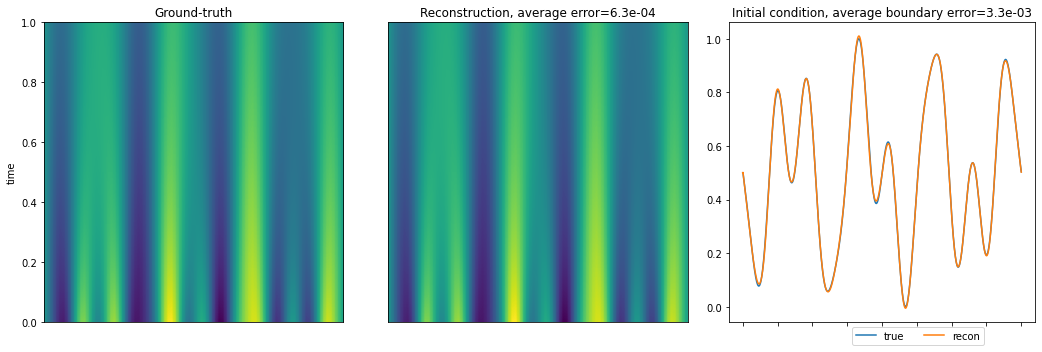

                                                  Histograms of error in task 1


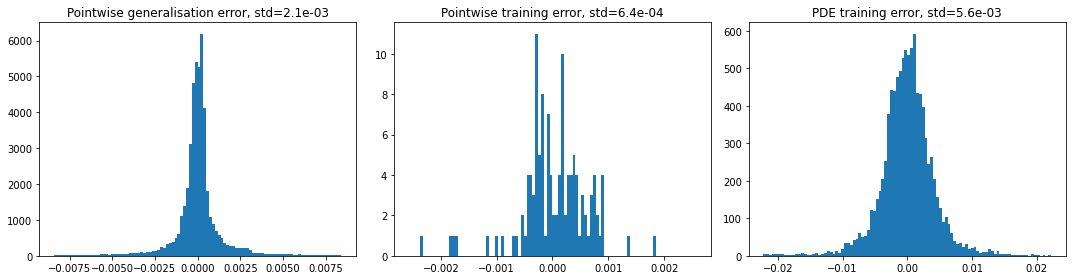

                                                  Plot of convergence in task 1


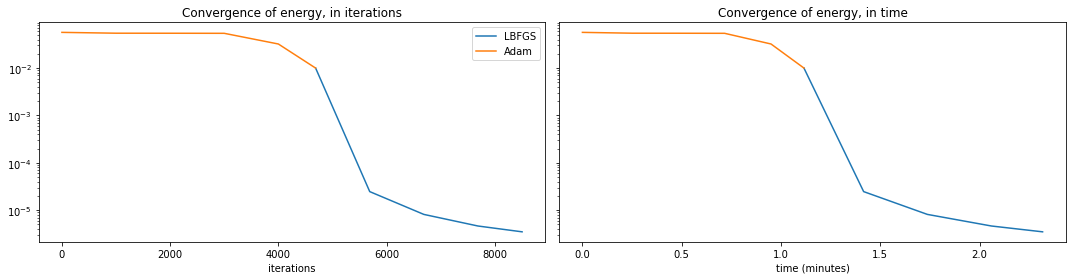

Computing Jacobian:   0%|          | 0/10120 [00:00<?, ?it/s]

In [8]:
#@title Solve task 1
name = 'heat'
taskify = compile_problem(name, seed=101)
u1, f1, boundary1, interior1, X1 = taskify(beta=1e-3, Nboundary=3e1, Nint=1e2)

# Train on task 1
M = PINNrun(boundary1, u1(boundary1), interior1, f1, layers=[60]*4, 
            optimise=(
                (1e4,'Adam',{'threshold':1e-2 if name=='heat' else 1e-3}),
                (1e4,'LBFGS')
            ))

print('\n\n' + ' '*50 + 'Solution to task 1 with just %d boundary points'%(boundary1.shape[0]//4))
# X_plot is high-resolution to give generalisation error
X_plot = np.concatenate(getEvalPoints2D(2000,200), axis=0)
U, V = u1(X_plot)[:,0], M.predict(X_plot)[:,0]
# plot trained model on full vector X
plotcompare2d(X_plot, U, V, plt.figure(figsize=(15,5)))
# plt.savefig('nn_adapt_perf')
plt.show(block=False)

print(' '*50 + 'Histograms of error in task 1')
# Plot generalisation and training errors on task 1
_, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, (arr,s) in enumerate([((u1(X_plot)-M.predict(X_plot))[:,0], 'Pointwise generalisation'),
                            (M.predict(M.X_u) - from_device(M.u_true), 'Pointwise training'),
                            (M.predict(M.X_f, constraint=True), 'PDE training')]):
    ax[i].hist(arr,range=[-4*arr.std(),4*arr.std()],bins=100)
    ax[i].set_title('%s error, std=%.1e'%(s,arr.std()))
plt.tight_layout()
plt.show(block=False)
# plt.savefig('histogram.png')

print(' '*50 + 'Plot of convergence in task 1')
plotHistory(M, plt.figure(figsize=(15,4)))
# plt.savefig('loss.png')
plt.show(block=False)

# Compute linearisation for inference on task 2
inference = AdaptiveInference(
    nn_model=M.u, trainset=TensorDataset(to_device(X1))
)


Computing Jacobian:   0%|          | 0/14000 [00:00<?, ?it/s]



                                                  Solution to task 2 adapted from task 1


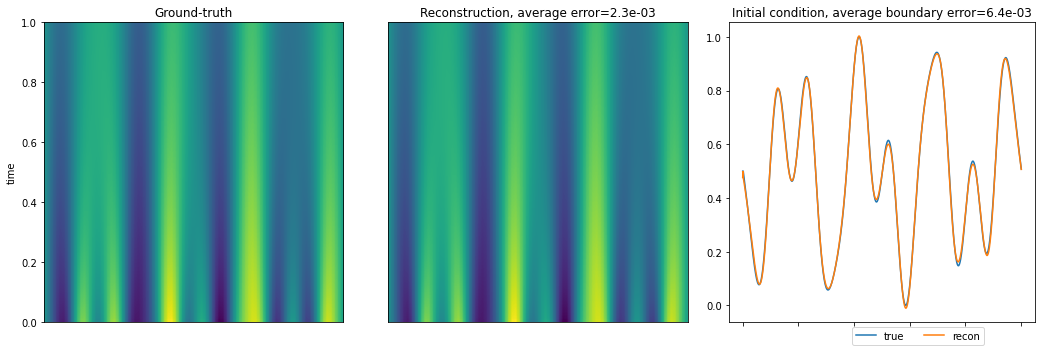

                    Comparison of errors between the solution to task 1 and the adapted task 2


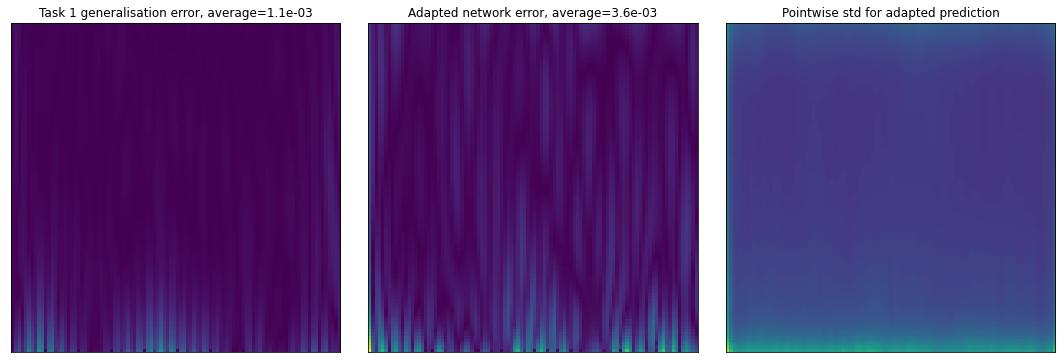

In [9]:
#@title Adapt to task 2
u2, f2, boundary2, interior2, X2 = taskify(beta=1e-3, Nboundary=1e3, Nint=1e2)

U = u2(X2)[:,0]
mu, cov = inference.predict(ys=to_device(X2), noise_var=1e0)
cov = cov.diag()
mu, cov = (from_device(T) for T in (mu,cov)) # cast to numpy

print('\n\n' + ' '*50 + 'Solution to task 2 adapted from task 1')
plotcompare2d(X2, U, mu, plt.figure(figsize=(15,5)))
# plt.savefig('adapt_dom_lin_nn_perf')
plt.show(block=False)

print(' '*20 + 'Comparison of errors between the solution to task 1 and the adapted task 2')
ax = plt.figure(figsize=(15,5)).subplots(1, 3)
tmp = abs(M.predict(X2)[:,0]-U), abs(mu-U)
scale = 1/max(arr.max() for arr in tmp)
for i, arr in enumerate(tmp):
    plot2d(ax[i], X2, scale * arr)
ax[0].set_title('Task 1 generalisation error, average=%.1e'%tmp[0].mean())
ax[1].set_title('Adapted network error, average=%.1e'%tmp[1].mean())
del tmp
plot2d(ax[2], X2, np.sqrt(np.maximum(cov,0)/cov.max()))
ax[2].set_title('Pointwise std for adapted prediction')
for a in ax:
    a.set_xticks([]); a.set_yticks([])
plt.tight_layout()
# plt.savefig('adapt_dom_lin_nn_uq.png')

## Final words
We couldn't find a combination of tasks 1 and 2 where the adapted performance on task 2 wasn't worse than the generalisation error of the model trained on task 1 then tested directly on task 2. It's not clear why this is. Statistically, there is a very naive prior on the adaptation procedure (basically Tychnohov regularisation on the linearised problem). This is competing against the fact that, when you find a good PINN solution, it really does generalise well.